In [1]:
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM, TimeDistributed, Dense, Activation, Dropout
from keras.models import Sequential
import time

import numpy as np
from numpy import newaxis

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 128
TIME_STEPS = 50

INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 32

EPOCHS = 100

PREDICT_HOW_MUCH_DAY_LATER = 1

normalize_yn = True
normalize_mode = 3

path = 'C:/Users/SensorTeam/Desktop/Da_workspace/stock/How-to-Predict-Stock-Prices-Easily-Demo-master'
filename = path + '/sp500.csv'

### Step1. Load Data

In [3]:
def load_data(filename, seq_len, normalise_window, how_much_day_later):
    
    f = open(filename, 'r').read()
    data = f.split('\n')
    
    ori_data = np.array(data[:-1]).astype(np.float)
    
    sequence_length = seq_len + how_much_day_later   
    result =[]
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        
    result_ori = np.array(result)  # to np array
    row = round (0.9 * result_ori.shape[0])  # 0.9 of data

    ori_y_test = result_ori[int(row):, -1 ]
        
    if normalise_window:
        result = normalise_windows(result, normalize_mode, ori_data)
        
    result = np.array(result)  # to np array
        
    train = result[:int(row),:]
    #np.random.shuffle(train)
    x_train = train[:,:-how_much_day_later ]
    y_train = train[:,-1 ]
    x_test = result[int(row):, :-how_much_day_later ]
    y_test = result[int(row):, -1 ]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return [x_train, y_train, x_test, y_test, ori_y_test]
    

In [4]:
def normalise_windows(window_data, mode, ori_data):
    normalised_data = []
    
    if (mode == 1) :
        for window in window_data:
            normalised_window = [((float(p) / float(window[0]) )- 1) for p in window]
            normalised_data.append(normalised_window)
        return normalised_data
    elif ( mode == 2):
        baseline = ori_data[0]
        for window in window_data:
            normalised_window = [((float(p) / float(baseline) )- 1) for p in window]
            normalised_data.append(normalised_window)
        return normalised_data
    elif ( mode == 3):
        min_num = min(ori_data)
        max_num = max(ori_data)        
        for window in window_data:
            normalised_window = [((float(p)-min_num )/(max_num-min_num)) for p in window]
            normalised_data.append(normalised_window)
        return normalised_data
    else:
        print ( 'Choose normalize mode !' )



In [5]:
X_train, y_train, X_test, y_test, ori_y_test = load_data(filename, TIME_STEPS, normalize_yn, PREDICT_HOW_MUCH_DAY_LATER)

### Step2. Build the model

In [6]:
model = Sequential()

model.add(LSTM(
    CELL_SIZE,
    input_shape = (TIME_STEPS, INPUT_SIZE),
    #batch_input_shape = (None,TIME_STEPS,INPUT_SIZE),
    return_sequences = False,
    #stateful = True
    ))
model.add(Dropout(0.2))

model.add(Dense(OUTPUT_SIZE))
model.add(Activation('linear'))

model.summary()

start = time.time()

model.compile(
    loss = 'mse',
    optimizer = 'rmsprop')

print ('compilation time: ', time.time() - start)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
compilation time:  0.027072429656982422


### Step3. Train the model

In [7]:
history = model.fit(
                X_train,
                y_train,
                batch_size = BATCH_SIZE,
                epochs =EPOCHS,
                validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/100
3523/3523 [==============================] - 4s - loss: 0.0249 - val_loss: 0.0061
Epoch 2/100
3523/3523 [==============================] - 2s - loss: 0.0042 - val_loss: 0.0024
Epoch 3/100
3523/3523 [==============================] - 2s - loss: 0.0034 - val_loss: 0.0032
Epoch 4/100
3523/3523 [==============================] - 2s - loss: 0.0030 - val_loss: 7.4354e-04
Epoch 5/100
3523/3523 [==============================] - 2s - loss: 0.0024 - val_loss: 0.0025
Epoch 6/100
3523/3523 [==============================] - 1s - loss: 0.0023 - val_loss: 7.0862e-04
Epoch 7/100
3523/3523 [==============================] - 2s - loss: 0.0021 - val_loss: 3.3865e-04
Epoch 8/100
3523/3523 [==============================] - 2s - loss: 0.0020 - val_loss: 5.0833e-04
Epoch 9/100
3523/3523 [==============================] - 2s - loss: 0.0018 - val_loss: 3.6540e-04
Epoch 10/100
3523/3523 [==============================] - 2s - loss: 0.0019 - val_loss:

In [8]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


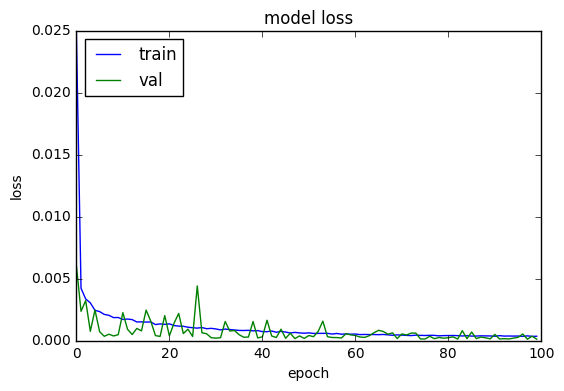

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Step4. Plot the Predictions

In [10]:
#0 - len(ori_y_test)

plt_day_range_f = 0
plt_day_range_t = len(ori_y_test)

In [11]:
def predict_sequences_multiple(model, data, window_size):
    prediction_seqs =[]
    
    for i in range(len(data)):
        curr_frame = data[i]
        prediction_seqs.append( model.predict(curr_frame[newaxis,:,:])[0,0] )  # for same to input format
    return prediction_seqs

In [12]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor = 'white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label = 'True Data')
    
    #for i, data in enumerate(predicted_data):
    #padding = [None for p in range(prediction_len)]     #Need How much None
    padding = []
    plt.plot(padding + predicted_data, label='Prediction' + '('+str(PREDICT_HOW_MUCH_DAY_LATER)+'day later)')       
    plt.legend()
        
    fig.savefig(path+'/'+str(time.time())+'.png')
    plt.show()


In [13]:
def find_cross(predictions, y_test):
    gold_cross_index = []
    dead_cross_index = []
    
    last_state = np.sign(predictions[0] - y_test[0])
    
    for index in range(len(predictions)):
        now_state = np.sign(predictions[index] - y_test[index])
        if ( last_state*now_state == -1 ):
            gold_cross_index.append(index) if (last_state == 1) else dead_cross_index.append(index)
        last_state = now_state
    
    return gold_cross_index, dead_cross_index

In [14]:
def plot_ori(real_y_test, gold_cross, dead_cross):
    fig = plt.figure(facecolor = 'white')
    ax = fig.add_subplot(111)
    ax.plot(real_y_test, label = 'Real Data')
    
    gold_cross = list( filter( lambda x: x > plt_day_range_f, gold_cross ) )
    gold_cross = list( filter( lambda x: x < plt_day_range_t, gold_cross ) )
    gold_cross = list( map( lambda x: x - plt_day_range_f, gold_cross ) )

    for index in range(len(gold_cross)):
        plt.annotate('Call',xy=(gold_cross[index],real_y_test[gold_cross[index]]),xytext=(gold_cross[index],float(real_y_test[gold_cross[index]])-5),arrowprops=dict(facecolor='red', shrink=0.05)) 
    
    dead_cross = list( filter( lambda x: x > plt_day_range_f, dead_cross ) )
    dead_cross = list( filter( lambda x: x < plt_day_range_t, dead_cross ) )
    dead_cross = list( map( lambda x: x - plt_day_range_f, dead_cross ) )
    for index in range(len(dead_cross)):
        plt.annotate('Put',xy=(dead_cross[index],real_y_test[dead_cross[index]]),xytext=(dead_cross[index],float(real_y_test[dead_cross[index]])+5),arrowprops=dict(facecolor='green', shrink=0.05)) 
    plt.show()

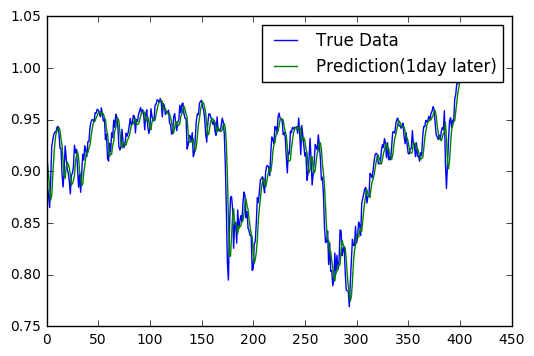

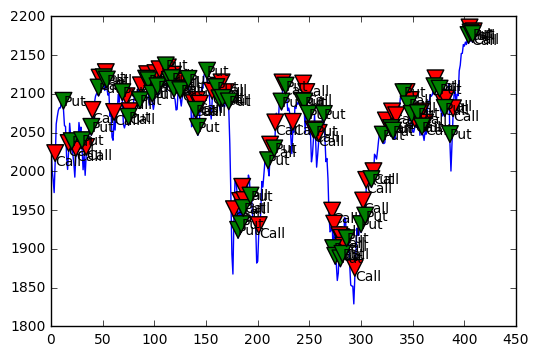

In [15]:
predictions = predict_sequences_multiple(model, X_test, TIME_STEPS)
plot_results_multiple(predictions[plt_day_range_f:plt_day_range_t], y_test[plt_day_range_f:plt_day_range_t], TIME_STEPS)

gold_cross, dead_cross = find_cross(predictions, y_test)
plot_ori(ori_y_test[plt_day_range_f:plt_day_range_t], gold_cross, dead_cross)


### Calculate Benefits

In [16]:
def cal_call(gold_cross, dead_cross):
    call_benefits={}
    call_costs = {}
    tot_benefit=0
    p_section = []
    n_section = []
    
    if (gold_cross[0] > dead_cross[0]):
        dead_cross = dead_cross[1:]
    
    trade_num = min(len(gold_cross), len(dead_cross))
    
    for index in range(trade_num):
        section_benefit = float(ori_y_test[dead_cross[index]]) -  float(ori_y_test[gold_cross[index]])
        
        tot_benefit += section_benefit
        
        if np.sign(section_benefit) == 1:
            p_section.append([gold_cross[index], dead_cross[index]])
            call_benefits[gold_cross[index]] = section_benefit
        else:
            n_section.append([gold_cross[index], dead_cross[index]])
            call_costs[gold_cross[index]] = section_benefit  
            
    return call_benefits, call_costs, tot_benefit, p_section, n_section
        

In [17]:
def transf_real(p_section, n_section, ori_y_test):
    p_section_real=[]
    n_section_real=[]
    
    p_i=0
    p_c=False 
    
    n_i=0
    n_c=False
    
    for index in range(len(ori_y_test)):

        if p_i >= len(p_section):
            None
        elif p_c:
            p_section_real.append(ori_y_test[index])
            p_c = False if p_section[p_i][1] == index else True
            p_i = p_i+1 if p_section[p_i][1] == index else p_i
        elif p_section[p_i][0] == index:
            p_section_real.append(ori_y_test[index])
            p_c=True
        else:
            p_section_real.append(None)

        if n_i >= len(n_section):
            None
        elif n_c:
            n_section_real.append(ori_y_test[index])
            n_c = False if n_section[n_i][1] == index else True
            n_i = n_i+1 if n_section[n_i][1] == index else n_i
        elif n_section[n_i][0] == index:
            n_section_real.append(ori_y_test[index])
            n_c=True
        else:
            n_section_real.append(None) 
            
    return p_section_real, n_section_real
    

In [18]:
def plot_p_n(ori_y_test, p_section_real, n_section_real):
    fig = plt.figure(facecolor = 'white')
    ax = fig.add_subplot(111)
    ax.plot(ori_y_test, label = 'Postive benefits')
    ax.plot(p_section_real,'r',linewidth = 3, label = 'Postive benefits')
    ax.plot(n_section_real,'k',linewidth = 3, label = 'Negative benefits')

    plt.show()

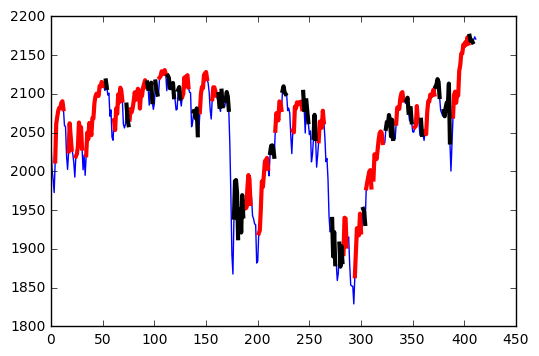

[(4, 67.46008299999994), (17, 2.3599859999999353), (24, 10.130004999999983), (34, 25.890014000000065), (40, 28.859863000000132), (47, 0.43994100000008984), (61, 25.550048999999944), (76, 14.219970999999987), (87, 8.520019999999931), (105, 4.959961000000021), (127, 12.290038999999979), (144, 42.589844000000085), (156, 4.790038999999979), (187, 5.739990000000034), (201, 83.65991200000008), (217, 26.850097000000005), (234, 27.219970999999987), (259, 24.390135999999984), (283, 9.670043999999962), (294, 56.48999099999992), (305, 0.910033999999996), (312, 47.14001499999995), (334, 29.760009000000082), (352, 7.320067999999992), (362, 46.80981500000007), (389, 94.39990200000011)]
26
[(53, -9.609864000000016), (73, -26.550048999999944), (93, -7.909912000000077), (96, -18.830077999999958), (101, -16.979980999999952), (113, -16.09008700000004), (116, -2.1298820000001797), (118, -18.22998000000007), (123, -11.089844000000085), (138, -8.659912000000077), (141, -34.660033999999996), (162, -16.280029

In [19]:
call_benefits,call_costs, tot_benefit, p_section, n_section = cal_call(gold_cross, dead_cross)

p_section_real, n_section_real = transf_real(p_section, n_section, ori_y_test)
plot_p_n(ori_y_test[plt_day_range_f:plt_day_range_t], p_section_real[plt_day_range_f:plt_day_range_t], n_section_real[plt_day_range_f:plt_day_range_t])

print (sorted(call_benefits.items()))
print (len(call_benefits))
print (sorted(call_costs.items()))
print (len(call_costs))
print (tot_benefit)



    

### Future work

1. 

### Reference
https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo